## Attached to UNIONS : The impact of systematic errors on weak-lensing peak counts

In [1]:
import numpy as np
import emcee
import numpy.linalg as la
import matplotlib.pyplot as plt
from getdist import plots, MCSamples, parampriors
from joblib import Parallel, delayed, cpu_count
from multiprocessing import cpu_count, Pool
import time
from chainconsumer import ChainConsumer
from utils import *
from likelihood import *
import os
import sys

In [2]:
#for tex in ChainConsumer
pref = os.environ['CONDA_PREFIX']
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

### Specify the free parameters for redshift, shear calibration, baryonic correction and cut in S/N

In [3]:
# Check the README to know the possibility for the different cases and reproduce the plots
param_z = '065' 
param_z_cov = '0.65'
param_cal = 'dm_1deg'
param_baryonic_correction = 'Fid'
param_cut = 19
n_patches = 13

### Load the file names for peaks file 

In [4]:
file_name_peaks_Maps = (np.array(np.loadtxt('.././input/list_cosmo_peaks_z{}.txt'.format(param_z), usecols=0,dtype=np.str)))

### Extract cosmological parameters values from the simulations associated to each peak counts file

In [5]:
params = np.array([takes_params(f) for f in file_name_peaks_Maps])

In [6]:
#identifies fiducial cosmology index
index_fiducial = 15
params_fiducial = params[index_fiducial]

In [7]:
params_fiducial

array([0.1, 0.3, 2.1])

### Download peaks distribution for theoretical prediction

In [8]:
#create the folder where to store the peaks distribution from the simulation
!mkdir ../input/peaks_z065/

#### !!! Before evaluating the next cell, do the following: 


- Download the peaks distribution for the theoretical prediction from [here](https://zenodo.org/record/6344515#.Yk2j6S0QOqA) with the following command on your terminal:

  *zenodo_get 10.5281/zenodo.6344515*
 
 this will download 238 MB on your local machine


- Store them in the folder **peaks_z065/** that you can find in the **input/** folder



In [10]:
#load the peaks distributions for the theoretical prediction
Peaks_Maps_DM = np.array([np.load('../input/peaks_z065/%s'%(fn), mmap_mode='r') for fn in file_name_peaks_Maps])[:,:,:param_cut]

In [11]:
#these are shaped as (#cosmologies, #realisations, #bins)
print(np.shape(Peaks_Maps_DM))

(99, 10000, 19)


### Load the different baryonic corrections

In [12]:
bar_corr = np.load('.././input/{}_correction.npy'.format(param_baryonic_correction))[:param_cut]

### Apply the baryonic correction

In [13]:
Peaks_Maps = np.copy(Peaks_Maps_DM)

if(param_baryonic_correction == 'no'):
    # no baryonic correction
    for i in range(Peaks_Maps_DM.shape[0]):
        for j in range(Peaks_Maps_DM.shape[1]):
            Peaks_Maps[i,j,:] = Peaks_Maps_DM[i,j,:] * 1
else:
    # apply the choosen baryonic correction
    for i in range(Peaks_Maps_DM.shape[0]):
        for j in range(Peaks_Maps_DM.shape[1]):
            Peaks_Maps[i,j,:] = Peaks_Maps_DM[i,j,:] * bar_corr
        
print(np.shape(Peaks_Maps))

(99, 10000, 19)


In [14]:
Peaks_Maps_mean=np.mean(Peaks_Maps, axis=1)

In [15]:
Peaks_Maps_mean.shape

(99, 19)

In [16]:
snr_array=np.linspace(-2,6,31)

In [17]:
snr_centers=0.5*(snr_array[1:]+snr_array[:-1])

### Load peaks distribution for data

In [18]:
peaks_data = np.load('.././input/peaks_mean_{}.npy'.format(param_cal), mmap_mode='r')[:param_cut]

### Train Gaussian Processes regressor

In [19]:
#this returns a tuple consisting of (list of GP, scaling)
gp_scaling=np.array([Parallel(n_jobs=8, verbose=5)(delayed(gp_train)(index_bin, params_train=params, obs_train=Peaks_Maps) for index_bin in range(Peaks_Maps.shape[2]))]).reshape(Peaks_Maps.shape[2], 2)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    6.9s remaining:    9.5s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:   10.4s remaining:    6.1s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:   11.6s remaining:    2.2s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:   13.6s finished


In [20]:
gp_scaling.shape

(19, 2)

In [21]:
gp_list=gp_scaling[:,0]
scaling=gp_scaling[:,1]

In [22]:
test = GP_pred(params_fiducial,gp_list,scaling)

## Covariance matrix

#### Load peaks to compute covariance matrix

In [23]:
cov_peaks_DM = np.load('.././input/convergence_gal_mnv0.00000_om0.30000_As2.1000_peaks_2arcmin_{}_b030_snr_min_max_ngal_7.npy'.format(param_z_cov), mmap_mode='r')[:,:param_cut]

In [24]:
print(np.shape(cov_peaks_DM))

(10000, 19)


#### Apply the baryonic correction

In [25]:
cov_peaks = np.copy(cov_peaks_DM)
for i in range(Peaks_Maps_DM.shape[1]):
    cov_peaks[i,:] = cov_peaks_DM[i,:] * bar_corr

print(np.shape(cov_peaks))

(10000, 19)


#### Compute covariance matrix and scale it for sky coverage

In [26]:
cov=(1/n_patches)*np.cov(cov_peaks.T)

#### Plot correlation matrix

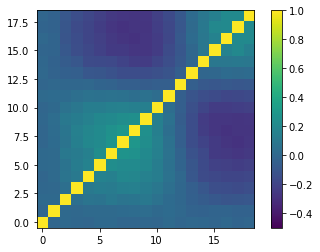

In [27]:
corr=np.corrcoef(cov_peaks.T)

plt.imshow(corr, origin='lower', vmin=-0.5,vmax=1)
plt.colorbar()

In [28]:
#compute the inverse of the covariance
icov=la.inv(cov)

In [29]:
print(np.shape(icov))

(19, 19)


### Get constraints with MCMC

#### Compute the Hartlap factor

In [30]:
n_real=Peaks_Maps_DM.shape[1]
n_bins=len(peaks_data)
norm=(n_real-n_bins-2)/(n_real-1)
print(norm)

0.997999799979998


#### Define values for the prior for the parameters

In [31]:
M_nu_min = 0.06  # minimum from oscillation experiments
M_nu_max = 0.62
Omega_m_min = 0.18
Omega_m_max = 0.42
A_s_min = 1.29
A_s_max = 2.91

#### Specify number of dimensions for parameter space, number of walkers, initial position

In [32]:
ndim, nwalkers = 3,250
pos = [params_fiducial +  1e-3*np.random.randn(ndim) for i in range(nwalkers)]

#### Run MCMC

In [33]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool=pool, args=[peaks_data, icov,gp_list, scaling, norm,M_nu_min, M_nu_max, Omega_m_min, Omega_m_max, A_s_min, A_s_max])
    start = time.time()
    sampler.run_mcmc(pos, 6500, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

samples = sampler.chain[:,200:, :].reshape((-1, ndim))

8 CPUs


100%|██████████| 6500/6500 [1:38:56<00:00,  1.09it/s]

Multiprocessing took 5937.3 seconds


In [34]:
samples = MCSamples(samples=samples,names = [r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

Removed no burn in


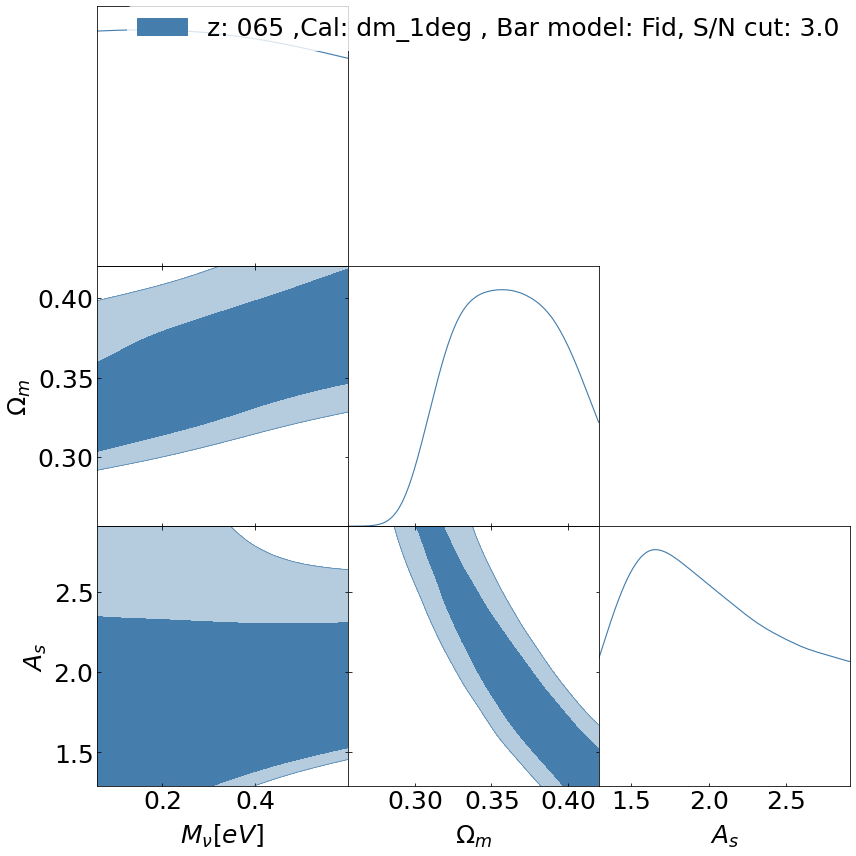

In [35]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 25
g.settings.axes_labelsize = 25
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = False
g.triangle_plot([samples],filled=True,
                legend_labels=['z: {} ,Cal: {} , Bar model: {}, S/N cut: {}'.format(param_z, param_cal, param_baryonic_correction, np.round(snr_centers[param_cut]), 1)],
               contour_colors=['#457EAC'])

In [36]:
np.save('.././output/constraints_z{}_{}_{}corr_{}snr.npy'.format(param_z,param_cal,param_baryonic_correction,param_cut),samples)

### Load the output

#### For every figure

In [37]:
constraints_global = np.load('.././output/constraints_z065_global_nocorr_30snr.npy')

#### Fig. 7 and Fig. 8

In [38]:
constraints_05deg = np.load('.././output/constraints_z065_05deg_nocorr_30snr.npy')
constraints_1deg = np.load('.././output/constraints_z065_1deg_nocorr_30snr.npy')
constraints_2deg = np.load('.././output/constraints_z065_2deg_nocorr_30snr.npy')
constraints_4deg = np.load('.././output/constraints_z065_4deg_nocorr_30snr.npy')
constraints_dm_1deg = np.load('.././output/constraints_z065_dm_1deg_nocorr_30snr.npy')

#### Fig. 9

In [39]:
constraints_z068 = np.load('.././output/constraints_z068_global_nocorr_30snr.npy')

#### Fig. 11

In [40]:
constraints_fidcorr = np.load('.././output/constraints_z065_global_Fidcorr_30snr.npy')
constraints_LowAGNcorr = np.load('.././output/constraints_z065_global_LowAGNcorr_30snr.npy')
constraints_HighAGNcorr = np.load('.././output/constraints_z065_global_HighAGNcorr_30snr.npy')

#### Fig. 12

In [41]:
constraints_cutsnr = np.load('.././output/constraints_z065_global_nocorr_19snr.npy')

#### Fig. 13

In [43]:
constraints_cons_model = np.load('.././output/constraints_z065_dm_1deg_Fidcorr_19snr.npy')

## Plotting example 

In [44]:
# Example for fig 13
samples_global = MCSamples(samples=constraints_global, names=[r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

samples_cons_model = MCSamples(samples=constraints_cons_model,names = [r"$M_{\nu}[eV]$","$\Omega_m$", r"$A_s$"], 
                                ranges={r"$M_{\nu}[eV]$":[0.06,0.6],"$\Omega_m$":[0.18,0.42], r"$A_s$":[1.29, 2.91]})

Removed no burn in
Removed no burn in


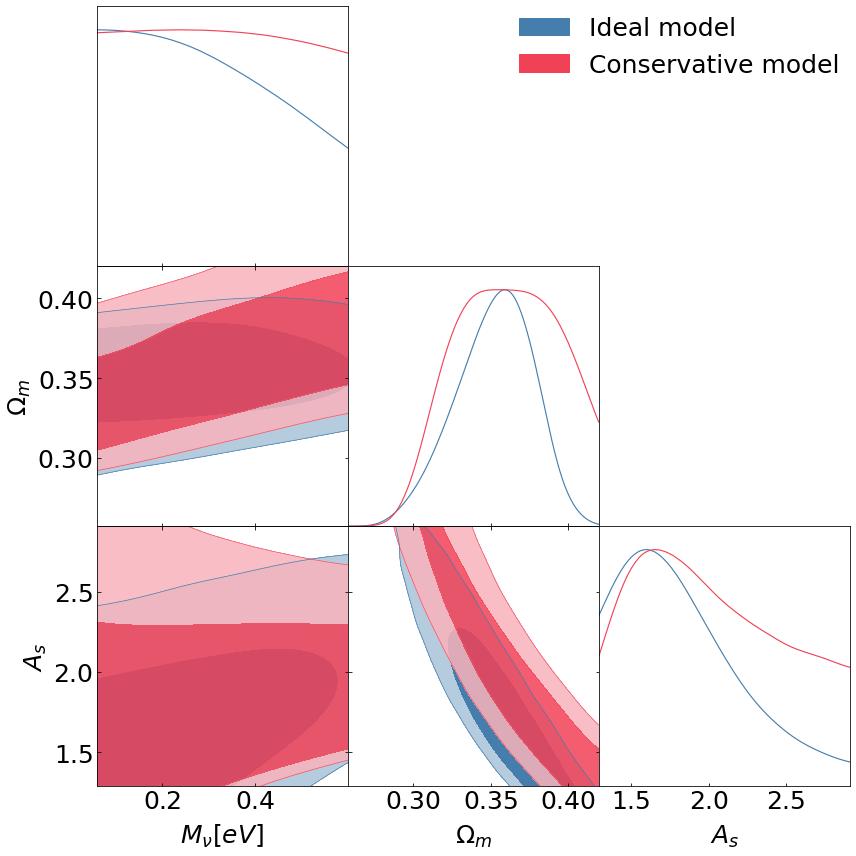

In [45]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 25
g.settings.axes_labelsize = 25
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = False
g.triangle_plot([samples_global,samples_cons_model],filled=True,
                legend_labels=['Ideal model', 'Conservative model'],
               contour_colors=['#457EAC','#F14156'])
plt.savefig('.././plot/constraints_ideal_conservative.png')

#### Fig. 14

In [46]:
# Fig 14: marginalised error bars
def get_instance():
    c = ChainConsumer()
    parameters = [r"$\sum M_{\nu} [eV]$","$\Omega_m$", r"$A_s$"]
    c.add_chain(constraints_global, parameters=parameters, name='Ideal model')
    c.add_chain(constraints_05deg, parameters=parameters, name='0.5° calibration')
    c.add_chain(constraints_1deg, parameters=parameters, name='1° calibration')
    c.add_chain(constraints_dm_1deg, parameters=parameters, name='1° calibration, $\Delta m = 0.007$')
    c.add_chain(constraints_2deg, parameters=parameters, name='2° calibration')
    c.add_chain(constraints_4deg, parameters=parameters, name='4° calibration')
    c.add_chain(constraints_z068, parameters=parameters, name='z = 0.68')
    c.add_chain(constraints_cutsnr, parameters=parameters, name='$-2 <$ SNR $< 3$')
    c.add_chain(constraints_LowAGNcorr, parameters=parameters, name='LowAGN baryonic correction')
    c.add_chain(constraints_fidcorr, parameters=parameters, name='Fiducial baryonic correction')
    c.add_chain(constraints_HighAGNcorr, parameters=parameters, name='HighAGN baryonic correction')
    c.add_chain(constraints_cons_model, parameters=parameters, name='Conservative model')
    return c

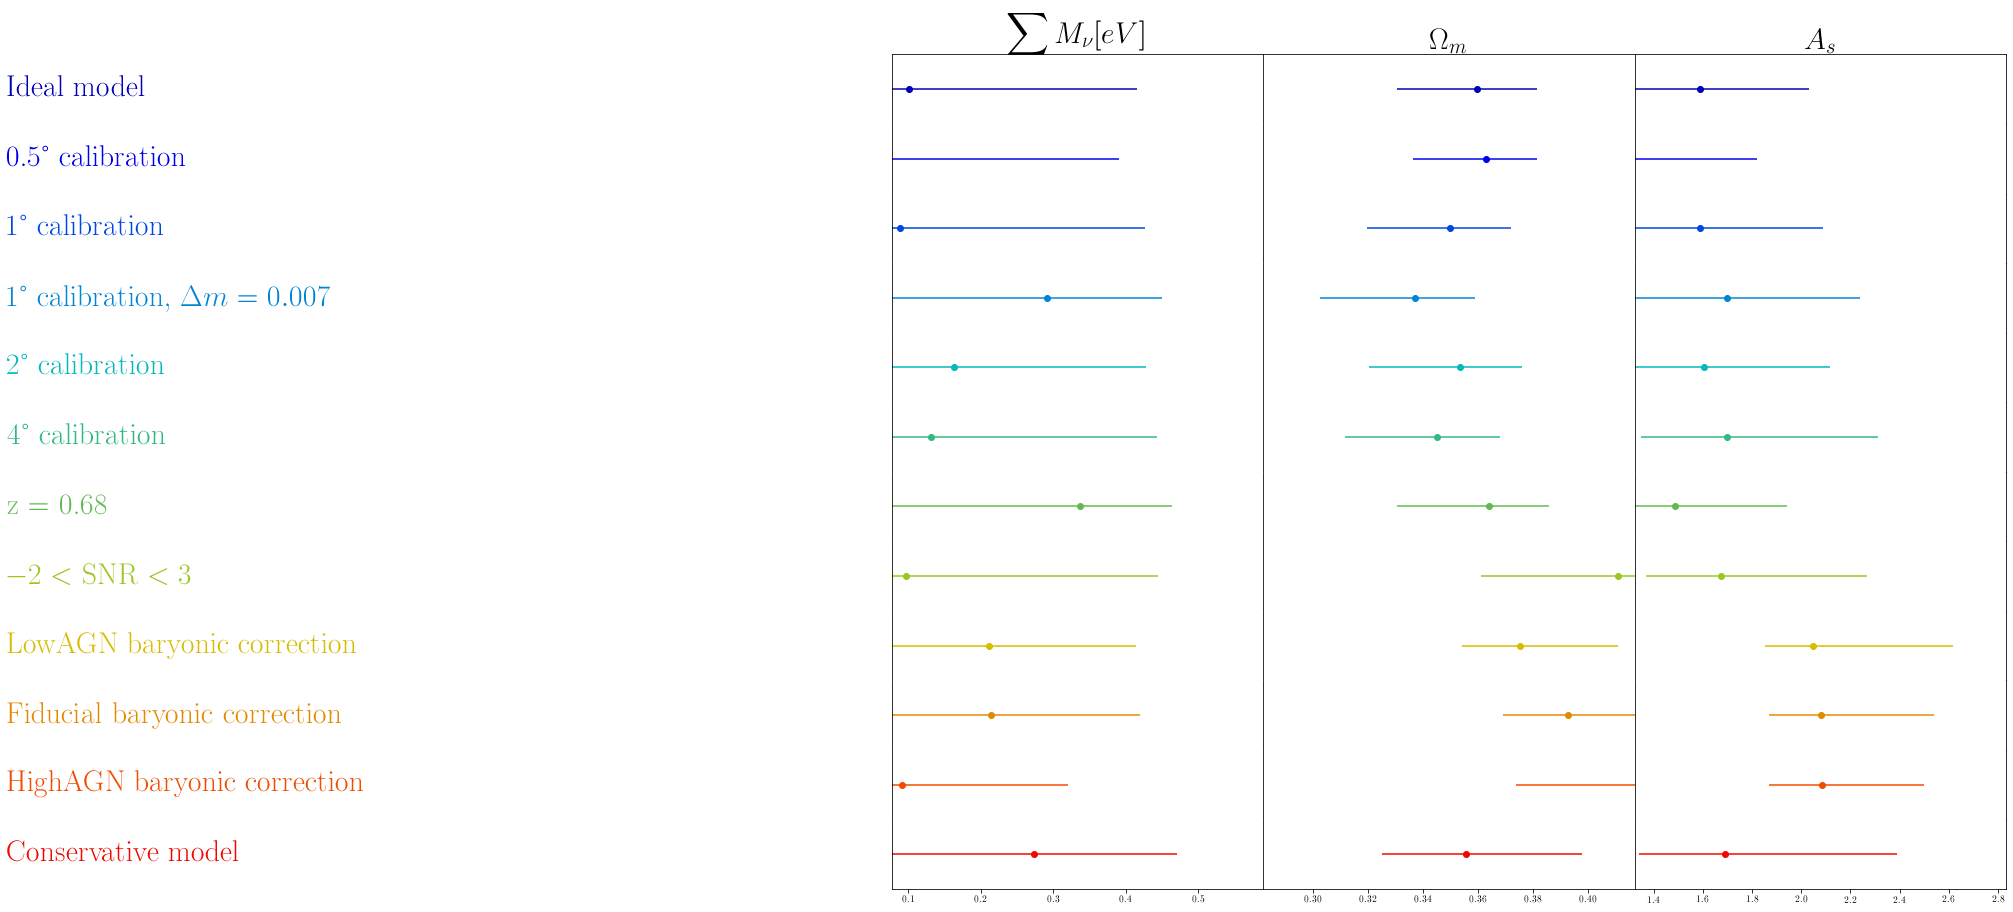

In [47]:
c = get_instance()
c.configure(legend_color_text=True,legend_kwargs={"fontsize": 35},tick_font_size=30, label_font_size=30,cmap='jet')
c.configure_truth(ls=":", color="#FB8C00")
fig = c.plotter.plot_summary(errorbar=True,filename='.././plot/resume.pdf',figsize=2)
fig.set_size_inches(5+fig.get_size_inches())  